In [ ]:

import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer
from xl_durel_utils import tokenize_truncate_decode, calculate_spearman, calculate_krippendorff, plot
from sentence_transformers import SentenceTransformer, models
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

/projekte/cik/shared/llm/XL-DURel/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load model and tokenizer

model = SentenceTransformer('sachinn1/xl-durel')
tokenizer = AutoTokenizer.from_pretrained("sachinn1/xl-durel")


In [3]:
# Load the datasets

dev_df = pd.read_pickle("/projekte/cik/shared/llm/thesis/Semantic_Proximity/data/comedi-wic-mclwic/dev.pkl")
test_df = pd.read_pickle("/projekte/cik/shared/llm/thesis/Semantic_Proximity/data/comedi-wic-mclwic/test.pkl")


In [4]:

# Compute cosine similarities
def compute_similarity(df):
    similarities = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Computing similarities"):
        sent1 = row["sentence1"]
        sent2 = row["sentence2"]
        pos1 = row["position1"]
        pos2 = row["position2"]

        try:
            context1 = tokenize_truncate_decode(sent1, pos1, tokenizer, max_seq_len=128)
            context2 =tokenize_truncate_decode(sent2, pos2, tokenizer, max_seq_len=128)
            emb1 = model.encode(context1, convert_to_tensor=True)
            emb2 = model.encode(context2, convert_to_tensor=True)
            
            sim = cosine_similarity(
                emb1.unsqueeze(0).cpu().numpy(),
                emb2.unsqueeze(0).cpu().numpy()
            )[0][0]

        except Exception as e:
            print(f"Failed : {e}")

        similarities.append(sim)

    df = df.copy()
    df["similarity"] = similarities
    return df

# Run it
dev_df_with_sim = compute_similarity(dev_df)
test_df_with_sim = compute_similarity(test_df)


Computing similarities: 100%|██████████| 21732/21732 [11:18<00:00, 32.02it/s]


/projekte/cik/shared/llm/XL-DURel/venv/lib64/python3.13/site-packages/xl_durel_utils/core.py:237: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = pivot_df.applymap(lambda x: f"{x:.2f}".lstrip("0") if pd.notnull(x) else "")


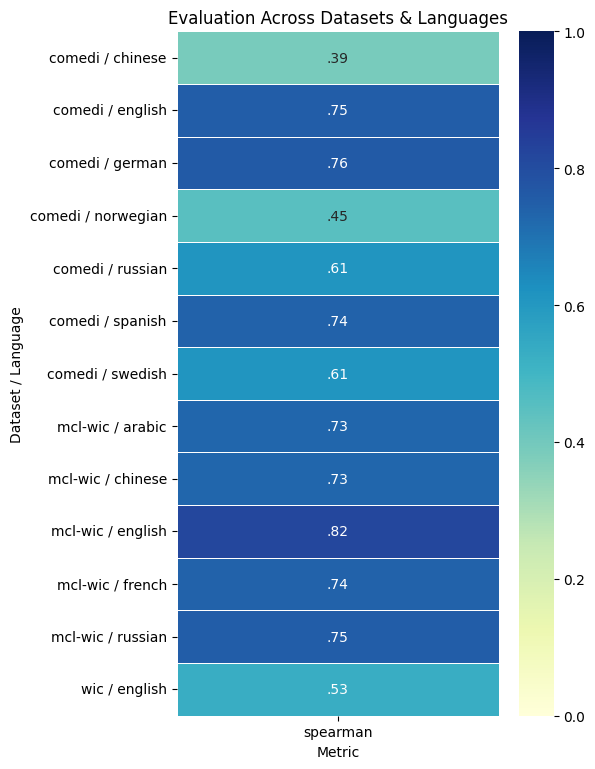

('comedi', 'chinese') [-inf, 0.5768068139405162, 0.6765002102091423, 0.7927116093351737, inf]
('comedi', 'english') [-inf, 0.32535901204859474, 0.48300452735758276, 0.6115888591099456, inf]
('comedi', 'german') [-inf, 0.32997490400345, 0.46455512615346295, 0.5999736878501423, inf]
('comedi', 'norwegian') [-inf, 0.2095633908339128, 0.33858932660964186, 0.4884544557715542, inf]
('comedi', 'russian') [-inf, 0.25539005328206443, 0.49066763335561997, 0.6147420218754426, inf]


('comedi', 'spanish') [-inf, 0.297084435862365, 0.5208179680553657, 0.62766399425355, inf]
('comedi', 'swedish') [-inf, 0.2898122908695373, 0.45185373610991797, 0.5643789604094149, inf]
('mcl-wic', 'arabic') [-inf, 0.6343780858907846, inf]
('mcl-wic', 'chinese') [-inf, 0.765556127484888, inf]
('mcl-wic', 'english') [-inf, 0.6679674176266422, inf]
('mcl-wic', 'french') [-inf, 0.6227151649072766, inf]
('mcl-wic', 'russian') [-inf, 0.593557770107873, inf]
('wic', 'english') [-inf, 0.5514793010661379, inf]


/projekte/cik/shared/llm/XL-DURel/venv/lib64/python3.13/site-packages/xl_durel_utils/core.py:237: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = pivot_df.applymap(lambda x: f"{x:.2f}".lstrip("0") if pd.notnull(x) else "")


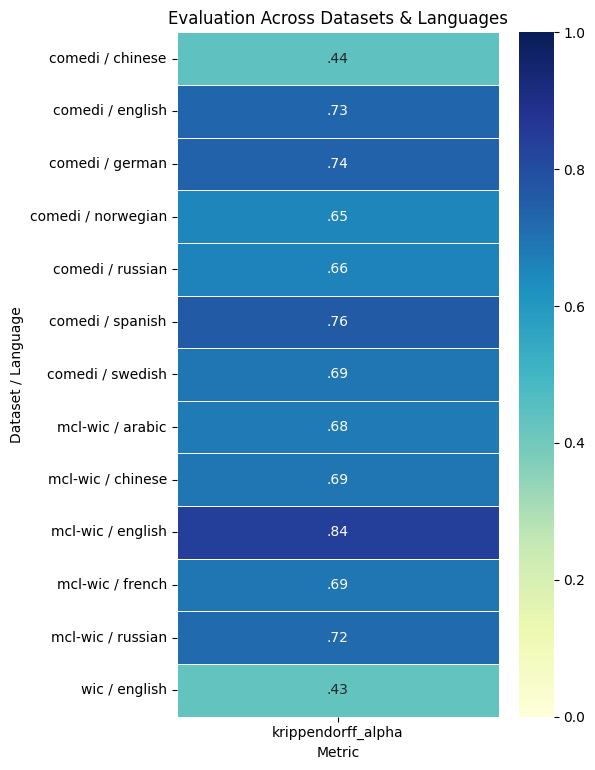

,dataset,language,pearson,spearman
0,comedi,chinese,0.454538,0.392829
1,comedi,english,0.755052,0.749389
2,comedi,german,0.759791,0.755932
3,comedi,norwegian,0.665988,0.452140
4,comedi,russian,0.715791,0.606997
5,comedi,spanish,0.808046,0.741645
6,comedi,swedish,0.743735,0.609296
7,mcl-wic,arabic,0.721826,0.731314
8,mcl-wic,chinese,0.728834,0.732658
9,mcl-wic,english,0.828520,0.818242


,dataset,language,krippendorff_alpha
0,comedi,chinese,0.444489
1,comedi,english,0.733866
2,comedi,german,0.738941
3,comedi,norwegian,0.649443
4,comedi,russian,0.656424
5,comedi,spanish,0.759724
6,comedi,swedish,0.685712
7,mcl-wic,arabic,0.675928
8,mcl-wic,chinese,0.692094
9,mcl-wic,english,0.836066


In [5]:
df1 =calculate_spearman(test_df_with_sim, ["dataset", "language"])
plot(df1, ["spearman"], ["dataset", "language"])    
df2 = calculate_krippendorff(dev_df_with_sim, test_df_with_sim, ["dataset", "language"])
plot(df2, ["krippendorff_alpha"], ["dataset", "language"])    

display(df1)
display(df2)
